In [2]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import warnings
warnings.filterwarnings("ignore")

import os
import glob
import matplotlib.pyplot as plt
# Keras API
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPooling2D,Activation,AveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

In [4]:
train_dir ="/content/drive/MyDrive/DRC02/Processed_dataset/train/"
test_dir="/content/drive/MyDrive/DRC02/Processed_dataset/val/"

In [5]:
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count=0
  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count+= len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count

In [6]:
train_samples =get_files(train_dir)
num_classes=len(glob.glob(train_dir+"/*"))
test_samples=get_files(test_dir) # For testing i took only few samples from unseen data. we can evaluate using validation data which is part of train data.
print(num_classes,"Classes")
print(train_samples,"Train images")
print(test_samples,"Test images")

6 Classes
1333 Train images
145 Test images


Preprocessing data

In [7]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   validation_split=0.2, # validation split 20%.
                                   horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)

set height and width and color of input image.

In [8]:
img_width,img_height =256,256
input_shape=(img_width,img_height,3)
batch_size =32

train_generator =train_datagen.flow_from_directory(train_dir,
                                                   target_size=(img_width,img_height),
                                                   batch_size=batch_size)
test_generator=test_datagen.flow_from_directory(test_dir,shuffle=True,
                                                   target_size=(img_width,img_height),
                                                   batch_size=batch_size)

Found 1326 images belonging to 6 classes.
Found 145 images belonging to 6 classes.


In [9]:
train_generator.class_indices

{'cercospora-leafspot': 0,
 'healthy': 1,
 'helmanthospura-leafspot': 2,
 'redrot': 3,
 'rust': 4,
 'yellow-leaf-disease': 5}

CNN Building

In [10]:
model = Sequential()
model.add(Conv2D(32, (5, 5),input_shape=input_shape,activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(32, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))   
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128,activation='relu'))          
model.add(Dense(num_classes,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 84, 84, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 82, 82, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 41, 41, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 39, 39, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 19, 19, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 23104)             0

In [11]:
model_layers = [ layer.name for layer in model.layers]
print('layer name : ',model_layers)

layer name :  ['conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'conv2d_2', 'max_pooling2d_2', 'flatten', 'dense', 'dropout', 'dense_1', 'dense_2']


Training model

In [12]:
validation_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(img_height, img_width),
    batch_size=batch_size)

Found 1326 images belonging to 6 classes.


In [27]:
opt=keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
train=model.fit_generator(train_generator,
                          epochs=10,
                          steps_per_epoch=train_generator.samples // batch_size,
                          validation_data=validation_generator,
                          validation_steps= validation_generator.samples// batch_size,verbose=1)

Epoch 1/10
41/41 [==============================] - 500s 12s/step - loss: 1.2009 - accuracy: 0.5695 - val_loss: 0.8116 - val_accuracy: 0.7104
Epoch 2/10
41/41 [==============================] - 478s 12s/step - loss: 0.8778 - accuracy: 0.6719 - val_loss: 0.8444 - val_accuracy: 0.6631
Epoch 3/10
41/41 [==============================] - 475s 12s/step - loss: 0.8696 - accuracy: 0.6695 - val_loss: 0.7979 - val_accuracy: 0.7218
Epoch 4/10
41/41 [==============================] - 475s 12s/step - loss: 0.8471 - accuracy: 0.6909 - val_loss: 0.8739 - val_accuracy: 0.6784
Epoch 5/10
41/41 [==============================] - 466s 11s/step - loss: 0.8413 - accuracy: 0.6881 - val_loss: 0.6601 - val_accuracy: 0.7630
Epoch 6/10
41/41 [==============================] - 479s 12s/step - loss: 0.7306 - accuracy: 0.7273 - val_loss: 0.6791 - val_accuracy: 0.7561
Epoch 7/10
41/41 [==============================] - 475s 12s/step - loss: 0.7625 - accuracy: 0.7225 - val_loss: 0.7476 - val_accuracy: 0.7218
Epoch 

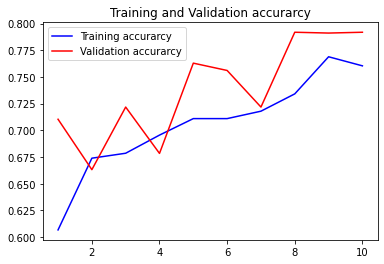

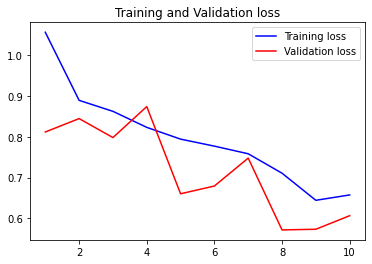

In [28]:
accuracy = train.history['accuracy']
val_accuracy = train.history['val_accuracy']
loss = train.history['loss']
val_loss = train.history['val_loss']
epochs = range(1, len(accuracy) + 1)
#Train and validation accuracy
plt.plot(epochs, accuracy, 'b', label='Training accurarcy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [29]:
score,accuracy =model.evaluate(test_generator,verbose=1)
print("Test score is {}".format(score))
print("Test accuracy is {}".format(accuracy))

5/5 [==============================] - 22s 4s/step - loss: 0.9074 - accuracy: 0.7517
Test score is 0.9074105024337769
Test accuracy is 0.751724123954773


In [30]:
from keras.models import load_model
model.save('crop.h5')

In [32]:
# Save model weights.
from keras.models import load_model
model.save_weights('crop_weights.h5')

In [33]:
# Get classes of model trained on
classes = train_generator.class_indices 
classes

{'cercospora-leafspot': 0,
 'healthy': 1,
 'helmanthospura-leafspot': 2,
 'redrot': 3,
 'rust': 4,
 'yellow-leaf-disease': 5}

In [34]:
# Loading model and predict.
from keras.models import load_model
model=load_model('crop.h5')

Classes = ["cercospora-leafspot","healthy","helmanthospura-leafspot","redrot","rust","yellow-leaf-disease"]

redrot


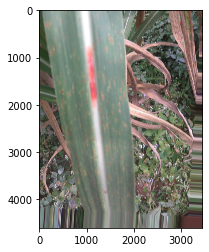

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Pre-Processing test data same as train data.
img_width=256
img_height=256
#model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

from keras.preprocessing import image

def prepare(img_path):
    img = image.load_img(img_path, target_size=(256, 256))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)
    
    
result = model.predict_classes([prepare('/content/drive/MyDrive/augm_data/redb10c_0_7145.jpg')])
disease=image.load_img('/content/drive/MyDrive/augm_data/redb10c_0_7145.jpg')
plt.imshow(disease)
print (Classes[int(result)])